<a href="https://colab.research.google.com/github/Vishal64B/Computer-Vision/blob/main/2347264_CV_Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

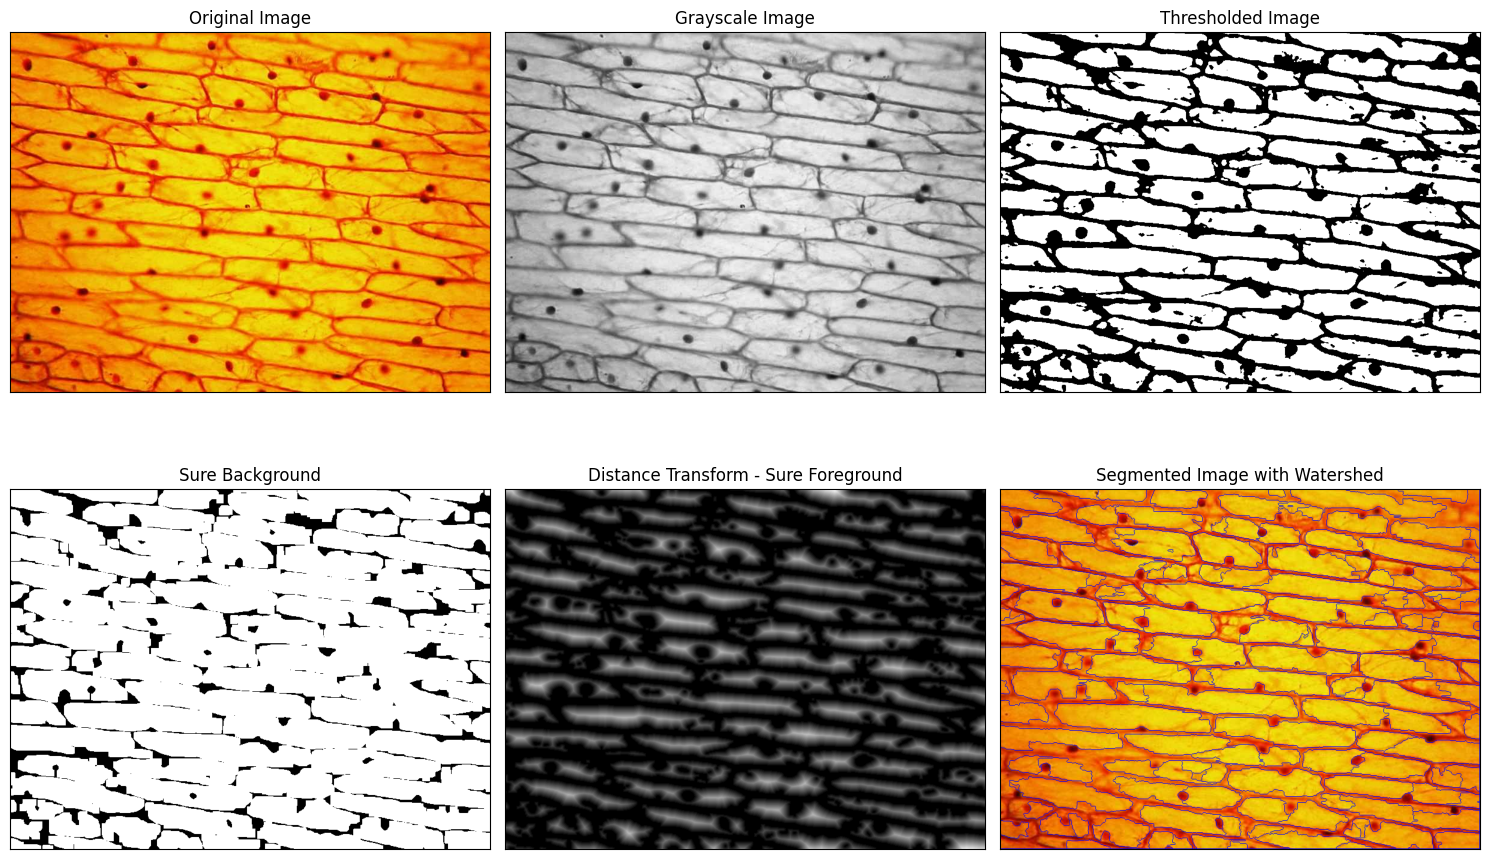

In [ ]:
# Importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology

# Load the image
image = cv2.imread('bananaCell.jpg')
if image is None:
    raise ValueError("Image not found. Please check the file path.")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1: Preprocessing
# Reduce noise with Gaussian Blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Enhance contrast using adaptive histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
contrast_enhanced = clahe.apply(blurred)

# Apply Otsu's thresholding to suppress background noise
_, thresh = cv2.threshold(contrast_enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 2: Marker Identification
# Morphological operations to remove noise and define background
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Identify foreground regions using distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Define unknown regions
unknown = cv2.subtract(sure_bg, sure_fg)

# Label markers for watershed
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Step 3: Watershed Segmentation
# Apply watershed algorithm to segment cells
markers = cv2.watershed(image, markers)

# Mark boundaries in the original image
segmented_image = image.copy()
segmented_image[markers == -1] = [255, 0, 0]  # Boundaries marked in red

# Display the results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 3, 2)
plt.title("Grayscale Image")
plt.xticks([])
plt.yticks([])
plt.imshow(gray, cmap='gray')

plt.subplot(2, 3, 3)
plt.title("Thresholded Image")
plt.xticks([])
plt.yticks([])
plt.imshow(thresh, cmap='gray')

plt.subplot(2, 3, 4)
plt.title("Sure Background")
plt.xticks([])
plt.yticks([])
plt.imshow(sure_bg, cmap='gray')

plt.subplot(2, 3, 5)
plt.title("Distance Transform - Sure Foreground")
plt.xticks([])
plt.yticks([])
plt.imshow(dist_transform, cmap='gray')

plt.subplot(2, 3, 6)
plt.title("Segmented Image with Watershed")
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()



This code performs image segmentation using the watershed algorithm to identify distinct objects (likely cells) in a microscopic image. Let's break down the code step-by-step:

1. **Image Loading and Preprocessing:**
   - Loads an image (`bananaCell.jpg`).
   - Converts the image to grayscale.
   - Applies Otsu's thresholding to create a binary image. Otsu's method automatically determines the optimal threshold value. `THRESH_BINARY_INV` inverts the binary image.
   - Uses bilateral filtering for noise reduction while preserving edges.  This is a more sophisticated noise reduction technique than simple morphological opening.

2. **Background and Foreground Identification:**
   - **Sure Background:**  Dilation is applied to the denoised image to expand the background region. This creates a "sure background" area.
   - **Sure Foreground:** Distance transform is used on the denoised image. This calculates the distance of each pixel from the nearest zero-value pixel (background). Then, a threshold is applied to the distance transform to find the "sure foreground."  Pixels with high distance values (far from the background) are considered part of the foreground.
   - **Unknown Region:** The difference between the "sure background" and the "sure foreground" is the "unknown region." This region contains pixels that could belong to either the background or foreground.

3. **Marker-Based Watershed Segmentation:**
   - **Connected Components:** The `connectedComponents` function labels each connected region of the "sure foreground" with a unique integer.
   - **Marker Labeling:**  A 1 is added to all labels, so the background is now labelled 1, and the sure foreground now has labels 2, 3, 4 etc. The "unknown region" is marked with 0.
   - **Watershed Algorithm:** The core segmentation step uses the watershed algorithm. It treats the image like a topographic surface where markers (obtained from the connected components) are placed on peaks. The algorithm simulates flooding the surface from these markers, with the "unknown region" representing valleys. The boundaries where the "waters" from different markers meet are the segmentation boundaries.  
   - **Highlighting Boundaries:** Pixels where the watershed algorithm detects boundaries are set to a distinct color (reddish-orange in this case, since `img[markers == -1] = [255,0,0]`).

**In Summary:** The code segments the image by identifying sure background and foreground regions and then using the watershed algorithm to delineate the boundaries between these regions. The boundaries are then highlighted on the original image.  The bilateral filter and distance transform help improve the accuracy of the segmentation by reducing noise and providing a more precise estimation of foreground objects. The watershed algorithm then uses this information to identify individual objects (cells in this case).
